<center><h1>Data 245: Project</h1>
    <h2>NBA Prediction</h2>

<h3>Imports

In [1]:
import numpy as np, scipy as sc, pandas as pd, requests
import xml.etree.ElementTree as ET
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats, playergamelog, playergamelogs, fantasywidget
from nba_api.stats.endpoints import infographicfanduelplayer, playerdashboardbylastngames, playernextngames
from nba_api.stats.endpoints import commonplayerinfo, commonallplayers
import json
import time
from IPython.display import Audio
from pulp import *
import inspect
from bs4 import BeautifulSoup
from urllib.request import urlopen

<h3>Notes

Scoring Rules:
- point +1
- rebound +1.25
- assist +1.5
- steal +2
- block +2
- turnover -0.5
- 3pt made +0.5
- 10x2 +1.5
- 10x3 +3

Gen restrictions:
- 8 players
- min 2 teams
- 1x5 basic positions, 1G, 1F, 1 Util

<h3>Sound (not neccessary for function)

In [2]:
'''
Audio Source:
https://mixkit.co/free-sound-effects/beep/
Positive Interface Beep
'''
sound_file = './sound/beep.wav'

<h3>Get Active Players

In [3]:
#workaround needed because in-built function broken, does not get rookies

In [4]:
x = commonallplayers.CommonAllPlayers().get_data_frames()[0]

In [5]:
active_players = x[x['TO_YEAR'] == '2020']

In [6]:
ap = list(active_players['PERSON_ID'])

In [7]:
len(ap)

542

In [8]:
#gets rid of players not 
mask = (active_players['TEAM_CITY'].str.len() > 0)
teamed_players = active_players.loc[mask]

In [9]:
tp = list(teamed_players['PERSON_ID'])

In [10]:
len(tp)

500

<h3>Team Stats DF

In [11]:
from nba_api.stats.static import teams
# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = teams.get_teams()

In [12]:
t_id_list = [i['id'] for i in nba_teams]

In [13]:
# Data mining code from https://github.com/billyhansen6/DraftKingsPredictions/blob/master/Basketball%20Project%20Data%20Downloads%20and%20Dump%20into%20SQL.ipynb
# minor modifications made
url = 'http://www.espn.com/nba/hollinger/teamstats'
html = requests.get(url).content
df_list = pd.read_html(html)
team_stats = df_list[-1]
team_stats = team_stats.drop(0, 1)
team_stats = team_stats.drop(0, 0)
team_stats = team_stats.drop(1, 0)
team_stats = team_stats.rename(columns={1: "TEAM", 
                                                    2:'PACE',
                                                    3: 'AST',
                                                    4: 'TURN_OVERS',
                                                    5: 'OFF_RATING',
                                                    6: 'DEF_RATING',
                                                    7: 'REBOUND_EFF',
                                                    8: 'EFF',
                                                    9: 'TS',
                                                    10: 'OFF_EFF',
                                                    11: 'DEF_EFF'})

In [14]:
team_dic = {'OKC': 'Oklahoma City', 'BKN': 'Brooklyn','MIA': 'Miami','ORL': 'Orlando',
                'MIN': 'Minnesota', 'SAS': 'San Antonio', 'BOS': 'Boston', 'NOP': 'New Orleans',
                'POR': 'Portland', 'PHI': 'Philadelphia', 'HOU': 'Houston', 'IND': 'Indiana',
                'MIL': 'Milwaukee', 'TOR': 'Toronto', 'CHI': 'Chicago', 'DEN': 'Denver',
                'ATL': 'Atlanta', 'CHA': 'Charlotte', 'NYK': 'New York', 'LAL': 'LA Lakers',
                'DAL': 'Dallas', 'WAS': 'Washington', 'GSW': 'Golden State', 'LAC': 'LA Clippers', 
                'PHX': 'Phoenix', 'SAC': 'Sacramento', 'DET': 'Detroit', 'UTA': 'Utah',
                'MEM': 'Memphis','CLE': 'Cleveland'}

In [15]:
inv_map = {v: k for k, v in team_dic.items()}

In [16]:
team_stats = team_stats.replace({'TEAM':inv_map})

<h3>Gamelog Dictionary

In [17]:
#gets a dictionary where the key is a player ID and the value is the players game log

In [18]:
Game_Logs = {}

In [19]:
e = 0
for player in ap:
    try:
        base = playergamelog.PlayerGameLog(player_id=player, timeout=1000).get_data_frames()
        Game_Logs[player] = base[0]
        time.sleep(0.600)
    except:
        if e < 7:
            e+=1
            time.sleep(45)
            #print(e)
            base = playergamelog.PlayerGameLog(player_id=player, timeout=1000).get_data_frames()
            Game_Logs[player] = base[0]
            continue
        else:
            print('break')
            break
Audio(sound_file, autoplay=True)

<h3>Next Games Dictionary

In [20]:
#get team: 1 player -> team: game -> player: game

In [21]:
Team_Player = {}

In [22]:
for row in active_players.iterrows():
    if (row[1]['TEAM_ABBREVIATION'] not in Team_Player.keys()) and (len(row[1]['TEAM_ABBREVIATION']) > 0) :
        Team_Player[row[1]['TEAM_ABBREVIATION']] = row[1]['PERSON_ID']

In [23]:
t_list = Team_Player.keys()

In [24]:
Team_Game = {}

In [25]:
for team in t_list:
    Team_Game[team] = playernextngames.PlayerNextNGames(player_id = Team_Player[team]).get_data_frames()[0].iloc[0]
    time.sleep(0.600)

In [26]:
Next_Games = {}

In [27]:
for player in tp:
    Next_Games[player] = Team_Game[teamed_players[teamed_players['PERSON_ID'] == player]['TEAM_ABBREVIATION'].iloc[0]]

<h3>Train, Validation, and Test Frame Creation

In [28]:
for player in ap:
    if len(Game_Logs[player]) == 0:
        Game_Logs.pop(player)

In [29]:
def dkings_score(row):
    try:
        threes = row['FG3M']
        r = row['REB']
        a = row['AST']
        s = row['STL']
        b = row['BLK']
        t = row['TOV']
        p = row['PTS']
        score = 0.5*threes + 1.25*r + 1.5*a + 2*s +2*b + -0.5*t + p
        dd = sum(1 for i in [p, r, a, s, b] if i>=10)
        if dd == 2:
            score += 1.5
        if dd > 2:
            score += 4.5
        return(score)
    except:
        print(row)
        pass

In [30]:
# Add rest days into dataframe

def resting(select_df):
    
    # Transform string of game_date to datetime format

    select_df['GAME_DATETIME'] = pd.to_datetime(select_df['GAME_DATE'], format='%b %d, %Y')
    select_df['GAME_DATENEW'] = select_df['GAME_DATETIME'].dt.date
    
    # Take diff between each date

    select_df['GAME_DATENEW']=pd.to_datetime(select_df['GAME_DATENEW'])
    select_df['REST_DAYS'] = select_df['GAME_DATENEW'].diff()
    
    # Rest days column is added

    select_df['REST_DAYS'] = select_df['REST_DAYS'].abs()

In [31]:
to_be_averaged= ['MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA',
       'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV',
       'PTS']

In [32]:
for frame in Game_Logs:
    x = Game_Logs[frame].reindex(index = Game_Logs[frame].index[::-1])
    if frame in tp:
        z = pd.DataFrame(0, index=np.arange(1, 2), columns=np.arange(27))
        z.columns = Game_Logs[frame].columns
        z['SEASON_ID'] = 22020
        z['Player_ID'] = frame
        z['Game_ID'] = Next_Games[frame]['GAME_ID']
        z['GAME_DATE'] = Next_Games[frame]['GAME_DATE']
        tplayer = teamed_players[teamed_players['PERSON_ID'] == frame]['TEAM_ABBREVIATION'].iloc[0]
        if tplayer == Next_Games[frame]['HOME_TEAM_ABBREVIATION']:
            z['MATCHUP'] = tplayer+' vs. '+ Next_Games[frame]['VISITOR_TEAM_ABBREVIATION']
        else:
            z['MATCHUP'] = tplayer+' @ '+ Next_Games[frame]['VISITOR_TEAM_ABBREVIATION']
        x = x.append(z, ignore_index=True)
    x['DKING_SCORE'] = x.apply(lambda row: dkings_score(row), axis=1)
    x['TEAM'] = x.apply(lambda row: row['MATCHUP'][:3], axis=1)
    x['OPPOSING_TEAM'] = x.apply(lambda row: row['MATCHUP'][-3:], axis=1)
    x['HOME_AWAY'] = x.apply(lambda row: 1 if '@' in row['MATCHUP'] else 0, axis = 1)
    x.rename({'WL': 'PREVIOUS_WL'})
    for column in to_be_averaged:
        x['SEASON_'+ column] = x[column].rolling(window = len(x), min_periods = 1).mean()
        x['5_GAME_AVG_'+ column] = x[column].rolling(window = 5, min_periods = 1).mean()
    Game_Logs[frame] = x.drop(['MIN', 'MATCHUP', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'], axis = 1)

In [33]:
not_shift = ['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE','DKING_SCORE',
       'TEAM', 'OPPOSING_TEAM', 'HOME_AWAY']

In [34]:
testing = Game_Logs[ap[0]]

In [35]:
to_shift = [i for i in testing.columns if i not in not_shift]

In [36]:
to_be_predicted = pd.DataFrame(columns = Game_Logs[tp[0]].columns)

In [37]:
for frame in Game_Logs:
    for column in to_shift:
        Game_Logs[frame][column]= Game_Logs[frame][column].shift(1)
    resting(Game_Logs[frame])
    Game_Logs[frame] = Game_Logs[frame][[c for c in Game_Logs[frame] if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]
    Game_Logs[frame] = Game_Logs[frame].iloc[1:]
    if frame in tp:
        to_be_predicted = to_be_predicted.append(Game_Logs[frame].iloc[[-1]], ignore_index=True)
        Game_Logs[frame] = Game_Logs[frame].iloc[:-1]

In [38]:
final_df = pd.concat(Game_Logs, axis= 0)
final_df = final_df.drop(['SEASON_ID', 'Player_ID', 'Game_ID', 'GAME_DATE', 'GAME_DATETIME', 'GAME_DATENEW'], axis = 1)
to_be_predicted = to_be_predicted.drop(['SEASON_ID', 'Game_ID', 'GAME_DATE', 'GAME_DATETIME', 'GAME_DATENEW'], axis = 1)

In [39]:
final_df['REST_DAYS'] = final_df.apply(lambda row: row['REST_DAYS'].days, axis=1)
to_be_predicted['REST_DAYS'] = to_be_predicted.apply(lambda row: row['REST_DAYS'].days, axis=1)

In [40]:
final_df = pd.merge(final_df, team_stats[['TEAM','PACE']], on = 'TEAM')
to_be_predicted = pd.merge(to_be_predicted, team_stats[['TEAM','PACE']], on = 'TEAM')

In [41]:
final_df = pd.merge(final_df, team_stats[['TEAM','PACE', 'TURN_OVERS', 'DEF_RATING']], left_on = 'OPPOSING_TEAM',
                   right_on = 'TEAM')
to_be_predicted = pd.merge(to_be_predicted, team_stats[['TEAM','PACE', 'TURN_OVERS', 'DEF_RATING']], left_on = 'OPPOSING_TEAM',
                   right_on = 'TEAM')

In [42]:
final_df = final_df.drop(['TEAM_x', 'OPPOSING_TEAM', 'TEAM_y'], axis = 1)
to_be_predicted = to_be_predicted.drop(['TEAM_x', 'OPPOSING_TEAM', 'TEAM_y'], axis = 1)

In [43]:
final_df = final_df[[c for c in final_df.columns if c != 'DKING_SCORE'] 
       + ['DKING_SCORE']]

In [44]:
final_df['WL'] = final_df['WL'].astype('category').cat.codes
to_be_predicted['WL'] = to_be_predicted['WL'].astype('category').cat.codes

In [45]:
to_be_predicted = to_be_predicted.set_index('Player_ID')

In [46]:
to_be_predicted = to_be_predicted.drop(['DKING_SCORE'], axis = 1)

<h3>Forecast Model Training

In [47]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [48]:
y = final_df['DKING_SCORE']
X = final_df.drop(columns = ['DKING_SCORE'])

In [96]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)

RandomForestRegressor()

In [50]:
to_be_predicted['predictions'] = regressor.predict(to_be_predicted)

<h3>Today's Players Selection and Pricing Incorporation

In [51]:
df1 = pd.read_csv('DK_CSVs/DK_5_7.csv')

In [52]:
# add AvgPointsPerGame to drop list for actual product
df1 = df1.drop(['Position', 'Name + ID', 'ID', 'Game Info', 'TeamAbbrev'], axis = 1)

In [53]:
for i in ['PG', 'SG', 'SF', 'PF', 'C']:
     df1[i] = df1.apply(lambda row: 1 if i in row['Roster Position'] else 0, axis = 1)

In [54]:
df1['G'] = df1.apply(lambda row: 1 if ((row['PG'] == 1) or (row['SG'] == 1)) else 0, axis = 1)
df1['F'] = df1.apply(lambda row: 1 if ((row['SF'] == 1) or (row['PF'] == 1)) else 0, axis = 1)
df1['UTIL'] = 1
df1 = df1.drop(['Roster Position'], axis = 1)

In [55]:
names_dic ={}
names_dic['PJ Washington'] = 'P.J. Washington'
names_dic['Robert Williams'] = 'Robert Williams III'
names_dic['Guillermo Hernangomez'] = 'Willy Hernangomez'
names_dic['KJ Martin Jr.'] = 'Kenyon Martin Jr.'
names_dic['Moe Harkless'] = 'Maurice Harkless' 
names_dic['TJ Leaf'] = 'T.J. Leaf'
names_dic['Jakarr Sampson'] = 'JaKarr Sampson'
names_dic['Charlie Brown'] = 'Charlie Brown Jr.'

In [56]:
df1 = df1.replace({'Name':names_dic})

In [57]:
df2 = pd.merge(df1, teamed_players[['PERSON_ID', 'DISPLAY_FIRST_LAST']], left_on = 'Name',
                   right_on = 'DISPLAY_FIRST_LAST').drop(['DISPLAY_FIRST_LAST'], axis = 1)

In [58]:
df3 = pd.merge(df2, to_be_predicted[['predictions']], left_on = 'PERSON_ID', right_index = True)
df3 = df3.reset_index(drop = True)

<h3>Injury Incorporation

In [59]:
# URL page we will scraping (see image above)
url = "https://www.basketball-reference.com/friv/injuries.fcgi"
# this is the HTML from the given URL
html = urlopen(url)
soup = BeautifulSoup(html)
injuries = []
for tr in soup.findAll('tr')[1:]:
    injury = tr.findAll('th')[0].getText()
    injuries.append(injury)

In [60]:
df3['INJURY'] = df3.apply(lambda row: 1 if row['Name'] in injuries else 0, axis=1)

<h3>Player Selection

In [61]:
people = list(df3['Name'])

In [62]:
prob = LpProblem("Player Choosing Problem", LpMaximize)

C:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1199: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [63]:
list_of_vars = [LpVariable(name, lowBound = 0, upBound = 1, cat = 'Integer') for name in people]

In [64]:
#Objective Func
prob += lpSum([df3.AvgPointsPerGame[i]*list_of_vars[i] for i in range(len(df3))])

In [65]:
#Salary Constraint
prob += sum([df3.Salary[i]*list_of_vars[i] for i in range(len(df3))]) <= 50000
prob += sum([list_of_vars[i] for i in range(len(df3))]) == 8
prob += sum([df3.INJURY[i]*list_of_vars[i] for i in range(len(df3))]) == 0
prob += sum([df3.PG[i]*list_of_vars[i] for i in range(len(df3))]) >= 1
prob += sum([df3.SG[i]*list_of_vars[i] for i in range(len(df3))]) >= 1
prob += sum([df3.SF[i]*list_of_vars[i] for i in range(len(df3))]) >= 1
prob += sum([df3.PF[i]*list_of_vars[i] for i in range(len(df3))]) >= 1
prob += sum([df3.C[i]*list_of_vars[i] for i in range(len(df3))]) >= 1
prob += sum([df3.G[i]*list_of_vars[i] for i in range(len(df3))]) >= 3
prob += sum([df3.F[i]*list_of_vars[i] for i in range(len(df3))]) >= 3

In [66]:
status = prob.solve()

In [67]:
for v in prob.variables ():
    if v.varValue == 1:
        print (v.name, "=", v.varValue)

Carmelo_Anthony = 1.0
Elfrid_Payton = 1.0
Enes_Kanter = 1.0
Evan_Fournier = 1.0
Giannis_Antetokounmpo = 1.0
Nikola_Jokic = 1.0
Tobias_Harris = 1.0
Tyler_Herro = 1.0


<h3>Appendix

In [68]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [85]:
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Scale data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [94]:
# #############################################################################
# Random Forest
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred, squared = False))
print('R2 Score:', metrics.r2_score(y_test, pred))

Mean Squared Error: 9.60142394497851
R2 Score: 0.5817641844525308


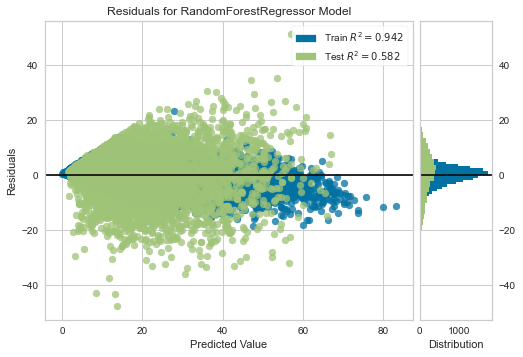

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [95]:
visualizer = ResidualsPlot(regressor)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()

In [71]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_test_lr= lr.predict(X_test)
print(mean_squared_error(y_test,pred_test_lr, squared = False))
print(r2_score(y_test, pred_test_lr))

9.5180348742065
0.58899745414822


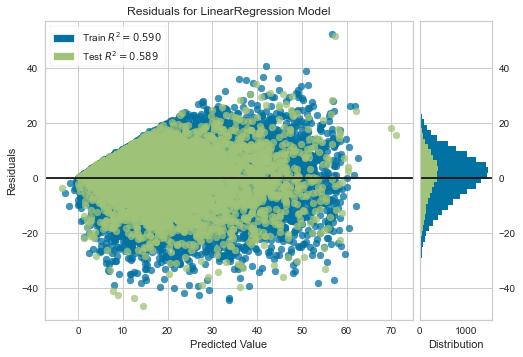

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [87]:
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

In [72]:
# #############################################################################
# Ridge Regression

rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 

pred_test_rr= rr.predict(X_test)
print(mean_squared_error(y_test,pred_test_rr, squared = False)) 
print(r2_score(y_test, pred_test_rr))

9.51803413683998
0.5889975178293284


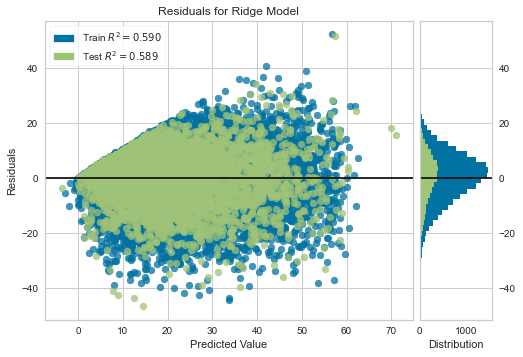

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [88]:
visualizer = ResidualsPlot(rr)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

In [73]:
# #############################################################################
# Lasso Regression

model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 

pred_test_lasso= model_lasso.predict(X_test)
print(mean_squared_error(y_test,pred_test_lasso, squared = False))
print(r2_score(y_test, pred_test_lasso))

9.512088212579675
0.5895108646561835


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 721.9097691611387, tolerance: 372.89196135155316
  model = cd_fast.enet_coordinate_descent(


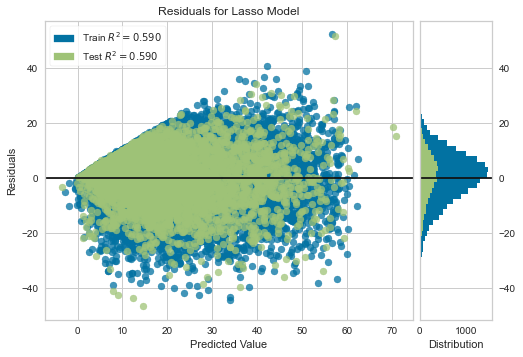

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [89]:
visualizer = ResidualsPlot(model_lasso)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

In [74]:
# #############################################################################
# ElasticNet (both Lasso and Ridge) Regression

model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 

pred_test_enet= model_enet.predict(X_test)
print(mean_squared_error(y_test,pred_test_enet, squared = False))
print(r2_score(y_test, pred_test_enet))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1008.6688111943658, tolerance: 372.89196135155316
  model = cd_fast.enet_coordinate_descent(


9.512289612225727
0.5894934818817746


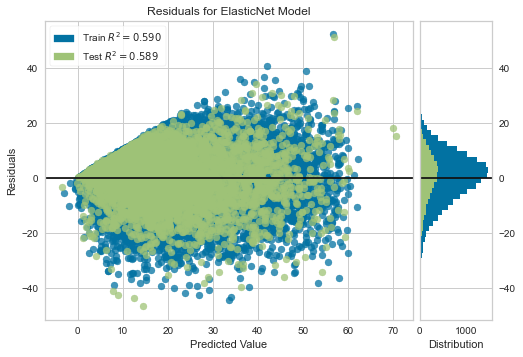

<AxesSubplot:title={'center':'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [90]:
visualizer = ResidualsPlot(model_enet)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.show()

In [91]:
# #############################################################################
# SVR
regr = SVR(kernel = 'rbf')
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(mean_squared_error(y_test,pred, squared = False))
print(r2_score(y_test, pred))

9.664393110221097
0.576260350834549


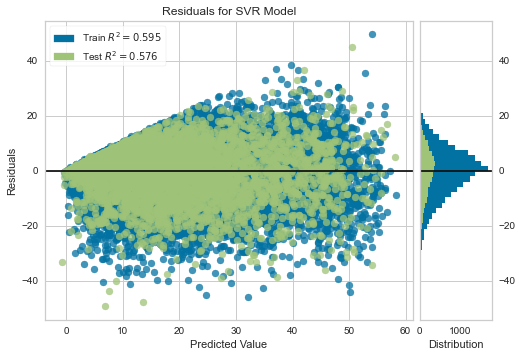

<AxesSubplot:title={'center':'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [92]:
visualizer = ResidualsPlot(regr)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)  
visualizer.show()

In [76]:
# #############################################################################
# KNeighbors Regression
neigh = KNeighborsRegressor(n_neighbors=15)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
print(mean_squared_error(y_test,pred, squared = False))
print(r2_score(y_test, pred))

9.689447093244608
0.574060496835525


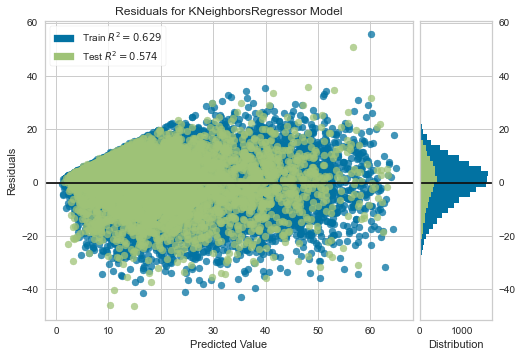

<AxesSubplot:title={'center':'Residuals for KNeighborsRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [93]:
visualizer = ResidualsPlot(neigh)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test) 
visualizer.show()

<AxesSubplot:>

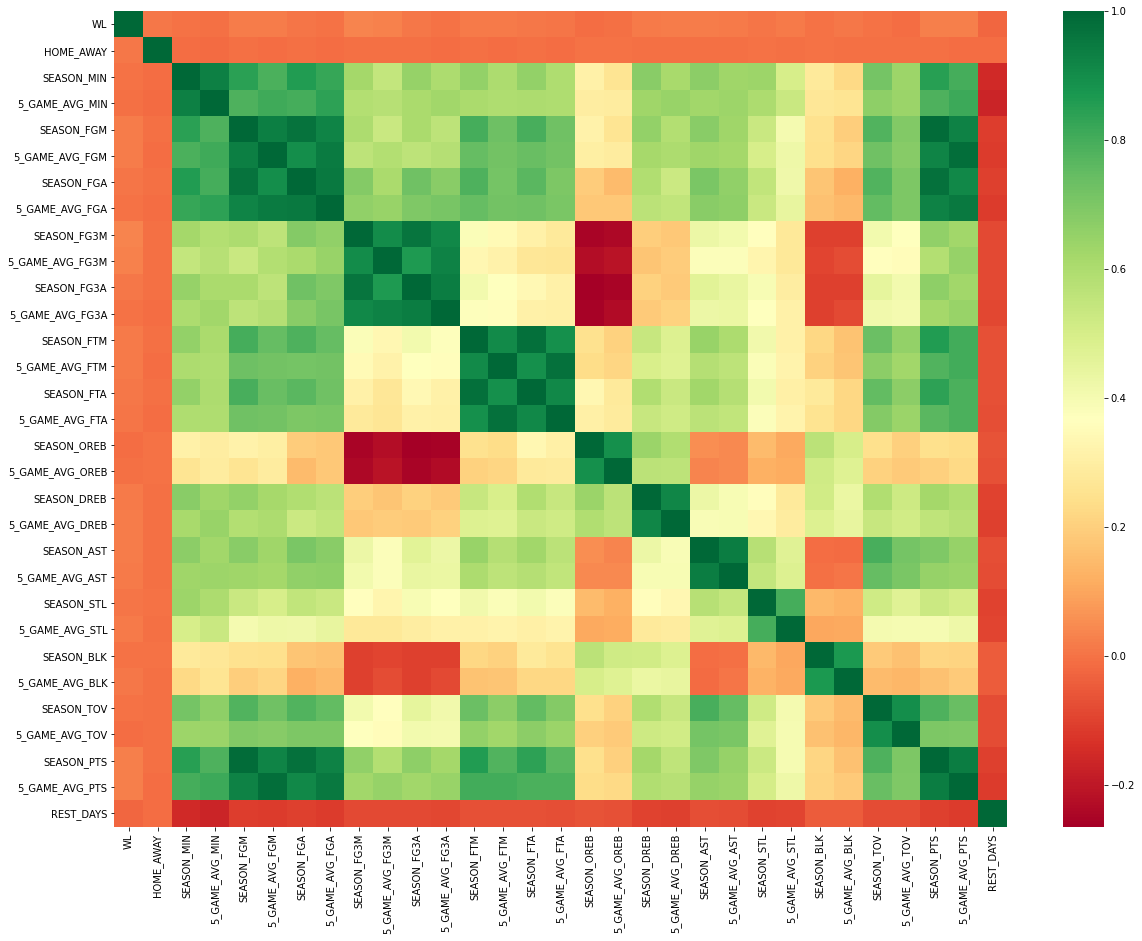

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(20,15))
sns.heatmap(X.corr(), cmap="RdYlGn")